In [62]:
import cv2
import numpy as np
import time
import sys
import os
import matplotlib.pyplot as plt

#### Подготовка сети

In [63]:
CONFIDENCE = 0.5
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5
# конфигурация нейронной сети
config_path = "object-detection/cfg/yolov3.cfg"
# файл весов сети YOLO
weights_path = "yolov3.weights"
# загрузка всех меток классов (объектов)
labels = open("object-detection/data/coco.names").read().strip().split("\n")
# генерируем цвета для каждого объекта и последующего построения
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

In [64]:
# загружаем сеть YOLO
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [65]:
path_name = "object-detection/images/city_scene.jpg"
image = cv2.imread(path_name)
file_name = os.path.basename(path_name)
filename, ext = file_name.split(".")

In [66]:
h, w = image.shape[:2]
# создать 4D blob
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

In [67]:
# устанавливает blob как вход сети
net.setInput(blob)
# получаем имена всех слоев
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
# прямая связь (вывод) и получение выхода сети
layer_outputs = net.forward(ln)

#### Ищем объекты

In [68]:
font_scale = 1
thickness = 1
boxes, confidences, class_ids = [], [], []
# перебираем каждый из выходов слоя
for output in layer_outputs:
    # перебираем каждое обнаружение объекта
    for detection in output:
        # извлекаем идентификатор класса (метку) и достоверность (как вероятность)
        # обнаружение текущего объекта
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        # отбросьте слабые прогнозы, убедившись, что обнаруженные
        # вероятность больше минимальной вероятности
        if confidence > CONFIDENCE:
            # масштабируем координаты ограничивающего прямоугольника относительно
            # размер изображения, учитывая, что YOLO на самом деле
            # возвращает центральные координаты (x, y) ограничивающего
            # поля, за которым следуют ширина и высота поля
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            # используем центральные координаты (x, y) для получения вершины и
            # и левый угол ограничительной рамки
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            # обновить наш список координат ограничивающего прямоугольника, достоверности,
            # и идентификаторы класса
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [69]:
# перебираем сохраняемые индексы
for i in range(len(boxes)):
    # извлекаем координаты ограничивающего прямоугольника
    x, y = boxes[i][0], boxes[i][1]
    w, h = boxes[i][2], boxes[i][3]
    # рисуем прямоугольник ограничивающей рамки и подписываем на изображении
    color = [int(c) for c in colors[class_ids[i]]]
    cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness)
    text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
    # вычисляем ширину и высоту текста, чтобы рисовать прозрачные поля в качестве фона текста
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
    text_offset_x = x
    text_offset_y = y - 5
    box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
    overlay = image.copy()
    cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
    # добавить непрозрачность (прозрачность поля)
    image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
    # теперь поместите текст (метка: доверие%)
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=font_scale, color=(0, 0, 0), thickness=thickness)

#### Отображение графики

(-0.5, 1525.5, 974.5, -0.5)

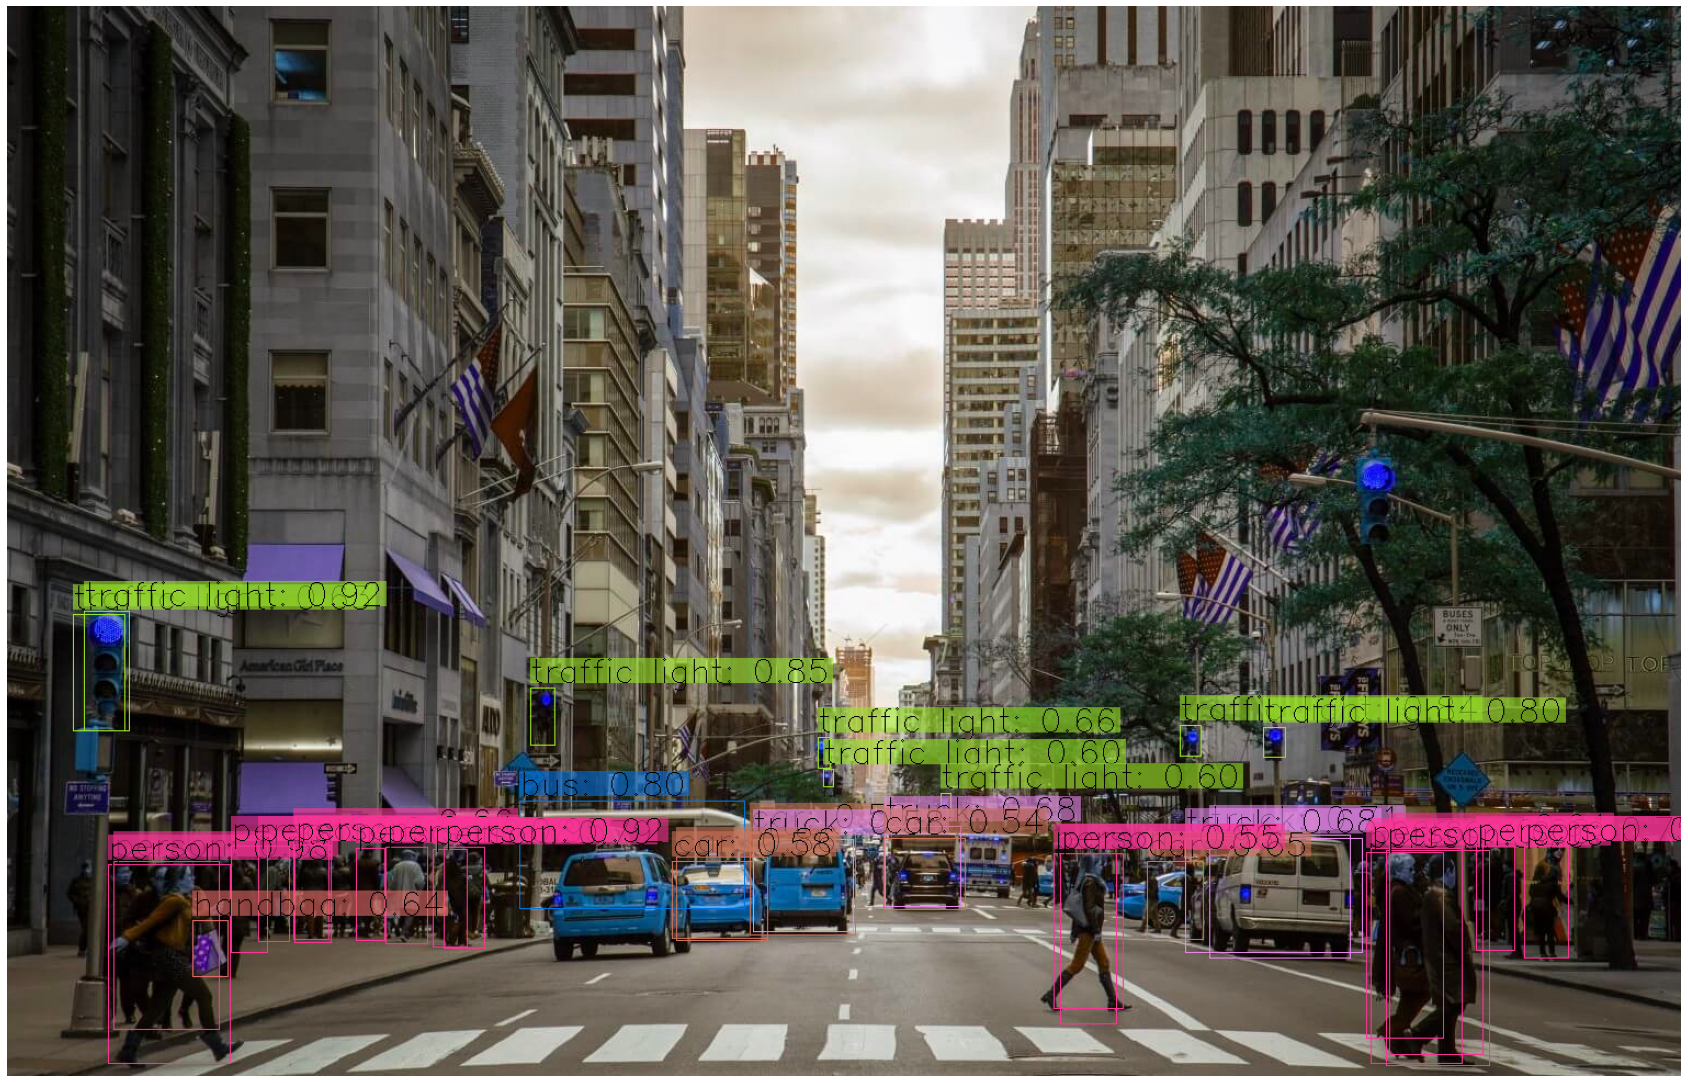

In [70]:
fig = plt.figure(figsize=(30, 20))
plt.imshow(image)
plt.axis('off')